# Price Gaps Modeling

Let's say we have demand driven by three things: Our product price, competition product price, and the gap in price between the two. Can we use OLS to recover the underlying coefficients from such a model?

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import uniform, normal, binomial, choice
from sklearn.linear_model import Ridge

import graphviz as gr
import pandas as pd

def simulate(**kwargs):
  """Helper function to simulate and plot a causal function"""
  values = {}
  g = gr.Digraph()
  for k,v in kwargs.items():
    parents = v.__code__.co_varnames
    inputs = {arg: values[arg] for arg in parents}
    values[k] = v(**inputs)
    for p in parents:
        g.edge(p,k)
  data = pd.DataFrame(values)
  return data, g

Create an example with price gaps

,our_price,comp_price,price_gap,demand
0,21.99,15.99,6.0,478.268836
1,22.99,14.99,8.0,475.938991
2,20.99,15.99,5.0,488.075952
3,22.99,14.99,8.0,472.578351
4,22.99,13.99,9.0,468.939814


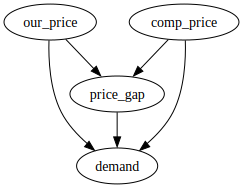

In [27]:
np.random.seed(42)

N = 250

df, g = simulate(
    our_price = lambda: choice([18.99, 19.99, 20.99, 21.99, 22.99, 23.99], N),
    comp_price = lambda: choice([12.99, 13.99, 14.99, 15.99, 16.99], N),
    price_gap = lambda our_price, comp_price: our_price - comp_price,
    demand = lambda our_price, comp_price, price_gap: normal(500 + (-1.7 * our_price) + (1.6 * comp_price) + (-1.25 * price_gap), 5)
)
display(df.head())
g

In this case, the price gap is not an interaction term but it's completely specified by `our_price` and `comp_price`. It's still a linear combination of 

In [21]:
df.corr()

,our_price,comp_price,price_gap,demand
our_price,1.000000,-0.005055,0.636632,-0.690041
comp_price,-0.005055,1.000000,0.765535,-0.710448
price_gap,0.636632,0.765535,1.000000,-0.991833
demand,-0.690041,-0.710448,-0.991833,1.000000


So yeah, we know multicollinearity is going to be bad here so I don't expect to see good estimates from OLS whenever we include it.

In [23]:
X = df[['our_price', 'comp_price', 'price_gap']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.989    
Dependent Variable: demand           AIC:                1530.8435
Date:               2024-01-11 16:48 BIC:                1544.9294
No. Observations:   250              Log-Likelihood:     -761.42  
Df Model:           3                F-statistic:        7745.    
Df Residuals:       246              Prob (F-statistic): 3.85e-243
R-squared:          0.990            Scale:              26.302   
-------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
const       497.3385   43.3557  11.4711  0.0000  411.9427  582.7343
our_price    -1.6913    2.0144  -0.8396  0.4020   -5.6589    2.2764
comp_price    1.7210    2.9007   0.5933  0.5535   -3.9923    7.4343
price_gap    -1.2475    0.1348  -9.2557  0.0000   -1.5130   -0.9821
------------------------------------------------------------------
Omnibus:              0.405         Durbin-Watson:           1.950
Prob(Omnibus):        0.817         Jarque-Bera (JB):        0.420
Skew:                 -0.096        Prob(JB):                0.811
Kurtosis:             2.941         Condition No.:           43595
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The condition number is large, 4.36e+04. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

Super bad

In [24]:
# Just prices?
X = df[['our_price', 'comp_price']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.986    
Dependent Variable: demand           AIC:                1603.5445
Date:               2024-01-11 16:48 BIC:                1614.1089
No. Observations:   250              Log-Likelihood:     -798.77  
Df Model:           2                F-statistic:        8620.    
Df Residuals:       247              Prob (F-statistic): 3.35e-229
R-squared:          0.986            Scale:              35.317   
------------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
------------------------------------------------------------------
const          895.5468   6.2127 144.1476 0.0000 883.3102 907.7834
our_price      -20.2523   0.2208 -91.7239 0.0000 -20.6872 -19.8174
comp_price     -25.0431   0.2653 -94.4088 0.0000 -25.5655 -24.5206
------------------------------------------------------------------
Omnibus:              0.409         Durbin-Watson:           1.973
Prob(Omnibus):        0.815         Jarque-Bera (JB):        0.198
Skew:                 -0.034        Prob(JB):                0.906
Kurtosis:             3.120         Condition No.:           434  
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

...

In [25]:
X = df[['our_price', 'price_gap']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.989    
Dependent Variable: demand           AIC:                1529.2010
Date:               2024-01-11 16:48 BIC:                1539.7654
No. Observations:   250              Log-Likelihood:     -761.60  
Df Model:           2                F-statistic:        1.165e+04
Df Residuals:       247              Prob (F-statistic): 3.76e-245
R-squared:          0.990            Scale:              26.233   
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|   [0.025   0.975] 
------------------------------------------------------------------
const         522.9466   4.1000  127.5466 0.0000 514.8711 531.0221
our_price      -2.8774   0.2468  -11.6611 0.0000  -3.3634  -2.3914
price_gap      -1.1678   0.0106 -109.9332 0.0000  -1.1887  -1.1469
------------------------------------------------------------------
Omnibus:              0.309         Durbin-Watson:           1.950
Prob(Omnibus):        0.857         Jarque-Bera (JB):        0.345
Skew:                 -0.084        Prob(JB):                0.842
Kurtosis:             2.929         Condition No.:           4115 
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The condition number is large, 4.11e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

No good here

In [26]:
X = df[['price_gap']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.984    
Dependent Variable: demand           AIC:                1636.8503
Date:               2024-01-11 16:48 BIC:                1643.8932
No. Observations:   250              Log-Likelihood:     -816.43  
Df Model:           1                F-statistic:        1.500e+04
Df Residuals:       248              Prob (F-statistic): 8.19e-224
R-squared:          0.984            Scale:              40.510   
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|   [0.025   0.975] 
------------------------------------------------------------------
const         486.5081   3.2986  147.4877 0.0000 480.0112 493.0050
price_gap      -1.2467   0.0102 -122.4609 0.0000  -1.2667  -1.2266
------------------------------------------------------------------
Omnibus:              0.470         Durbin-Watson:           1.890
Prob(Omnibus):        0.791         Jarque-Bera (JB):        0.238
Skew:                 -0.026        Prob(JB):                0.888
Kurtosis:             3.142         Condition No.:           2655 
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The condition number is large, 2.66e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

Looks like there's just no way to really estimate it here unless the true impact of the price gap is that much larger than the prices themselves - not likely. 

## Ridge

Okay, how about Ridge regression to help regularize...

In [8]:
ridge_model = Ridge(alpha=1)
X = df[['our_price', 'comp_price', 'price_gap']]
y = df['demand']
ridge_model.fit(X, y)
ridge_model.coef_

array([-1.03166026,  0.89521969, -1.92687995])

Same issue